In [89]:
from whstudy import WorldIndicators
from sklearn.manifold import TSNE
from ProjectionCorrelation import score_projections
from Orange.data.pandas_compat import table_from_frame
from Orange.data import ContinuousVariable
from Orange.preprocess import Normalize
import matplotlib.pyplot as plt

import random

### Get data from mongo database

In [90]:
handle = WorldIndicators('main', 'biolab')
country_codes = ['USA', 'CAN', 'FRA', 'GER', 'MEX', 'CHN', 'IND', 'HRV',
                 'SVN', 'ITA', 'BRA', 'BGR', 'BIH', 'BOL', 'BWA', 'FIN', 'ESP', 'MDG', 'PRT']

reference = handle.data(country_codes, ['EN.ATM.GHGT.KT.CE', 'EG.ELC.ACCS.ZS', 'AG.LND.FRST.ZS'], range(2000,2020)).dropna(axis=0, how='any')
overlay = handle.data(country_codes, ['GC.DOD.TOTL.GD.ZS', 'SE.PRM.UNER.ZS', 'EN.POP.SLUM.UR.ZS', 'SL.UEM.TOTL.ZS',
                                      'AG.YLD.CREL.KG', 'SH.STA.TRAF.P5'], range(2000,2020)).dropna(axis=1, how='any')

### Split data to reference and overlay and perform t-SNE and scoring

In [91]:
ref_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(reference.to_numpy())

tSNE_X = ContinuousVariable("t-SNE-x")
tSNE_Y = ContinuousVariable("t-SNE-y")

overlay_table = table_from_frame(overlay)
ref_table = table_from_frame(reference)
ref_table = ref_table.add_column(tSNE_X, ref_tsne[:, 0], to_metas=True)
ref_table = ref_table.add_column(tSNE_Y, ref_tsne[:, 1], to_metas=True)

scores = score_projections(ref_table, tSNE_X, tSNE_Y, overlay_table)


### Draw visualization of good and bad features

     2000-SL.UEM.TOTL.ZS  2001-SL.UEM.TOTL.ZS  2002-SL.UEM.TOTL.ZS  2003-SL.UEM.TOTL.ZS  2004-SL.UEM.TOTL.ZS  2005-SL.UEM.TOTL.ZS  2006-SL.UEM.TOTL.ZS  2007-SL.UEM.TOTL.ZS  2008-SL.UEM.TOTL.ZS  2009-SL.UEM.TOTL.ZS  2010-SL.UEM.TOTL.ZS  2011-SL.UEM.TOTL.ZS  2012-SL.UEM.TOTL.ZS  2013-SL.UEM.TOTL.ZS  2014-SL.UEM.TOTL.ZS  2015-SL.UEM.TOTL.ZS  2016-SL.UEM.TOTL.ZS  2017-SL.UEM.TOTL.ZS  2018-SL.UEM.TOTL.ZS  2019-SL.UEM.TOTL.ZS  2000-AG.YLD.CREL.KG  2001-AG.YLD.CREL.KG  2002-AG.YLD.CREL.KG  2003-AG.YLD.CREL.KG  2004-AG.YLD.CREL.KG  2005-AG.YLD.CREL.KG  2006-AG.YLD.CREL.KG  2007-AG.YLD.CREL.KG  2008-AG.YLD.CREL.KG  2009-AG.YLD.CREL.KG  2010-AG.YLD.CREL.KG  2011-AG.YLD.CREL.KG  2012-AG.YLD.CREL.KG  2013-AG.YLD.CREL.KG  2014-AG.YLD.CREL.KG  2015-AG.YLD.CREL.KG  2016-AG.YLD.CREL.KG  2017-AG.YLD.CREL.KG  2018-AG.YLD.CREL.KG  2000-SH.STA.TRAF.P5  2001-SH.STA.TRAF.P5  2002-SH.STA.TRAF.P5  2003-SH.STA.TRAF.P5  2004-SH.STA.TRAF.P5  2005-SH.STA.TRAF.P5  2006-SH.STA.TRAF.P5  2007-SH.STA.TRAF.P5  2008-SH.

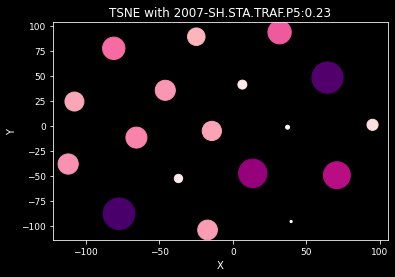

2006-SH.STA.TRAF.P5:0.2476541550001788
(18, 1)
(18, 2)


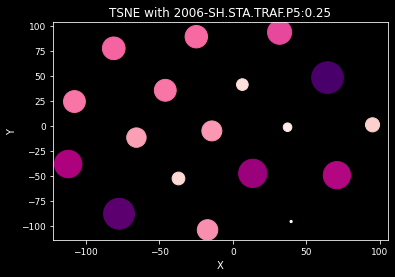

(18, 1)
(18, 2)


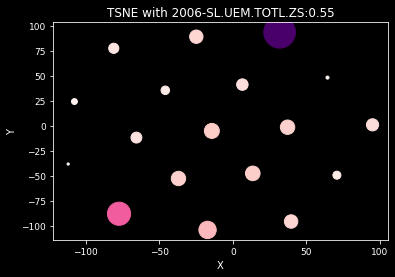

(18, 1)
(18, 2)


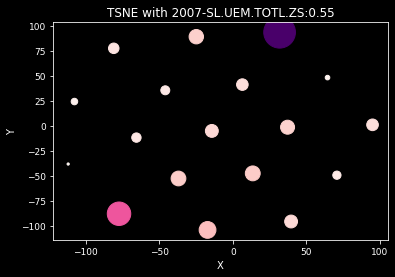

In [92]:
print(overlay.to_string())
print(reference.to_string())

def plot_score(f_name, f_score, arr):
    values = 5 + 1000 * arr[:, f_name].X_df.to_numpy()
    plt.scatter(ref_tsne[:, 0], ref_tsne[:, 1], s=values, c=values, cmap='RdPu')

    plt.title(f"TSNE with {f_name}:{f_score:.2f}")
    plt.xlabel("X", fontsize=10)
    plt.ylabel("Y", fontsize=10)
    plt.tick_params(axis="both", which='major', labelsize=9)
    plt.show()


norm = Normalize(norm_type=Normalize.NormalizeBySpan, zero_based=True)
out = norm(overlay_table)

# Find best score and display

sorted_scores = sorted(scores, key=lambda tup: tup[1])

plt.style.use('dark_background')

for (name, score) in sorted_scores[:2]:
    print(f"{name}:{score}")
    plot_score(name, score, out)

for (name, score) in sorted_scores[-2:]:
    plot_score(name, score, out)